In [1]:
import xarray as xr
import datetime as dt
import os
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')

from distance import distance_calculator,pointdist_calc,get_angle
from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
from scipy import ndimage
from calendar import monthrange
from scipy.interpolate import RegularGridInterpolator


In [2]:
def round_to_nearest_half_hour(t):
    if t.minute < 15:
        return t.replace(minute=0, second=0, microsecond=0)
    elif t.minute < 45:
        return t.replace(minute=30, second=0, microsecond=0)
    else:
        if t.hour < 23:
            return (t.replace(hour=t.hour + 1, minute=0, second=0, microsecond=0))
        else:
            days_in_month = monthrange(t.year, t.month)[1]
            if tc_radar_time.day + 1 >  days_in_month:
                return(t.replace(month = t.month+1,day=1, hour=0,
                                             minute=0, second=0,microsecond=0))
            else:
                return(t.replace(day=t.day + 1, hour=0, minute=0, second=0,microsecond=0))

In [4]:
height = 2
# small_tilt_list = []
# large_tilt_list = []
# rmw_small_tilt = []
# rmw_large_tilt = []
# tilt_mag_large_list = []
# tilt_mag_small_list = []
# all_last_slices = []

all_last_slices = []
full_info_arr_list = []

vmax_arr_list = []

rad_list = []
cylindrical_normalized_list = []
        
imerg_centering = '2-km Center'

polar_boolean = True

swath_boolean = True
if swath_boolean == True:
    
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_1997_2019_xy_rel_swath_ships.nc?download=1',
                     '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_2020_2022_xy_rel_swath_ships.nc?download=1']   
else:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']

for nc_file in nc_file_paths:
    
    tc_radar_data_pre = xr.open_dataset(nc_file)
    
    if swath_boolean == True:
    # Snip TC-RADAR Dataset to times wit IMERG data (2000 and later)
        good_inds = tc_radar_data_pre['swath_year'].where(tc_radar_data_pre['swath_year']>=2000).dropna('num_cases')['num_cases']
        tc_radar_data = tc_radar_data_pre.sel(num_cases = good_inds)

        # Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
        years,months,days,hours,minutes = tc_radar_data['swath_year'].values,\
            tc_radar_data['swath_month'].values,tc_radar_data['swath_day'].values,\
            tc_radar_data['swath_hour'].values,tc_radar_data['swath_min'].values                
    else:
    # Snip TC-RADAR Dataset to times wit IMERG data (2000 and later)
        good_inds = tc_radar_data_pre['merge_year'].where(tc_radar_data_pre['merge_year']>=2000).dropna('num_cases')['num_cases']
        tc_radar_data = tc_radar_data_pre.sel(num_cases = good_inds)

        # Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
        years,months,days,hours,minutes = tc_radar_data['merge_year'].values,\
            tc_radar_data['merge_month'].values,tc_radar_data['merge_day'].values,\
            tc_radar_data['merge_hour'].values,tc_radar_data['merge_min'].values


    # Find file paths and download any files not in directory

    timedeltas = [-60,-30,0,30] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h
    # timedeltas = [0] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h

    filepaths = []
    rounded_time_list = []
    for i in range(len(tc_radar_data['num_cases'])):
        curr_time_filepaths = []
        for times in timedeltas:
            tc_radar_time = dt.datetime(years[i],months[i],days[i],hours[i],minutes[i])
            rounded_time = round_to_nearest_half_hour(tc_radar_time)
            time_desired = rounded_time + dt.timedelta(minutes=times)
            print(i,tc_radar_time,rounded_time)

            year = time_desired.year
            day_of_year = time_desired.strftime('%j')
            day_stripped = time_desired.strftime('%Y%m%d')
            time_stripped = time_desired.strftime('%H%M%S')
            min_of_day = str(time_desired.hour*60 + time_desired.minute).zfill(4)
            end_time_stripped = (time_desired+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')

            # If IMERG file does not exist, download it
            IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
                '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
                '.'+min_of_day+'.V07B.HDF5'
            curr_time_filepaths.append(IMERG_file_path)
            print(IMERG_file_path)
            print(os.path.exists(IMERG_file_path))

                # If day directory does not exist, make day directory
            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year))

            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

            if os.path.exists(IMERG_file_path) == False:
                url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
                    +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
                    '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
                os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

                os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                          + url_desired)
        filepaths.append(curr_time_filepaths)
        rounded_time_list.append(rounded_time)

    all_time_filepaths = pd.DataFrame(filepaths)
    all_time_filepaths.index = tc_radar_data['num_cases'].astype(int)

    time_list_pd = pd.DataFrame(rounded_time_list)
    time_list_pd.index = tc_radar_data['num_cases'].astype(int)

    for case_loop in tc_radar_data['num_cases'].astype(int).values: # Run all
#     for case_loop in [90]: # Custom Start and End

        # Only do storms that are tropical or subtropical, if neither, continue loop
        stype_ships = float(tc_radar_data['stype_ships'].sel(num_cases=case_loop,num_ships_times = 0).values)
        if (stype_ships != 1) and (stype_ships != 2):
            print('skipped '+ str(case_loop))
            continue

        # Open IMERG
            print(case_loop)
        precip_list = []
        for now_it in range(len(all_time_filepaths.loc[case_loop])):
            fn = all_time_filepaths.loc[case_loop][now_it]
            f = h5py.File(fn, 'r')

            # Work on precip file
            groups = [ x for x in f.keys() ]
            # print(groups)
            gridMembers = [ x for x in f['Grid'] ]
            # print(gridMembers)

            # Get the precipitation, latitude, and longitude variables
            precip = f['Grid/precipitation'][0][:][:]
            precip = np.transpose(precip)
            precip[precip<-999]=np.nan

            theLats = f['Grid/lat'][:]
            theLons = f['Grid/lon'][:]
            x, y = np.float32(np.meshgrid(theLons, theLats))

            precip_list.append(precip)

        # For now, we take a mean. Might need a different filter in the future
        precip_mean = np.mean(np.asarray(precip_list),axis=0)

        # Find interpolated storm-center
        # Get Storm Name and time
        storm_name = str(tc_radar_data['storm_name'].sel(num_cases=case_loop).values)

        # Overall Subplot Title
        bt_vmax = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values
        bt_intensity_arr = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).values
        
#         if sorting_type == 'tilt': # We only do weak storms for tilt sorting
#             if float(bt_vmax) > 65: # Only record weak storm cases
#                 print('Skipped '+ str(case_loop) + ' due to strong storm of ' + str(bt_vmax) + ' kt')
#                 continue
        
        nearest_30_min_ts = time_list_pd.loc[case_loop][0].timestamp()
        bt_times = tc_radar_data.sel(num_cases=case_loop)['num_ships_times'].where(tc_radar_data.sel(num_cases=case_loop)['lat_ships'].notnull()).dropna('num_ships_times').values
        bt_lats = tc_radar_data.sel(num_cases=case_loop)['lat_ships'].dropna('num_ships_times').values
        bt_lons = tc_radar_data.sel(num_cases=case_loop)['lon_ships'].dropna('num_ships_times').values * -1

        if swath_boolean == True:
            year_now,month,day,hour,minute = tc_radar_data['swath_year'].sel(num_cases=case_loop).values,\
                tc_radar_data['swath_month'].sel(num_cases=case_loop).values,tc_radar_data['swath_day'].sel(num_cases=case_loop).values,\
                tc_radar_data['swath_hour'].sel(num_cases=case_loop).values,tc_radar_data['swath_min'].sel(num_cases=case_loop).values
        else:
            year_now,month,day,hour,minute = tc_radar_data['merge_year'].sel(num_cases=case_loop).values,\
                tc_radar_data['merge_month'].sel(num_cases=case_loop).values,tc_radar_data['merge_day'].sel(num_cases=case_loop).values,\
                tc_radar_data['merge_hour'].sel(num_cases=case_loop).values,tc_radar_data['merge_min'].sel(num_cases=case_loop).values

        radar_time = dt.datetime(year_now,month,day,hour,minute)
        nearest_syn_ts = pd.DataFrame([radar_time])[0].dt.round("6h")[0].timestamp()

        time_secs_arr = nearest_syn_ts + (bt_times * 3600)

        # Don't plot best-track (SHIPS) center if there is no information
        if imerg_centering == '2-km Center':
            centering_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=height).values
            centering_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=height).values
            # For cases that use 2-km centering, we need a center here to exist, duhh
            if (str(centering_lat) == 'nan') or (str(centering_lon) == 'nan'): 
                print('No Center, skipped')
                continue
        elif imerg_centering == 'best-track':
            if len(bt_lats) > 0:
                latspl = UnivariateSpline(time_secs_arr,bt_lats,k=2,s=0)
                centering_lat = latspl(nearest_30_min_ts)
            if len(bt_lons) > 0:
                lonspl = UnivariateSpline(time_secs_arr,bt_lons,k=2,s=0)
                centering_lon = lonspl(nearest_30_min_ts)

        # Find index closest to interpolated best-track center or 2-km radar center
        distance_arr = distance_calculator(x, y,(centering_lon,centering_lat))

        abs_dist_arr = (abs(distance_arr))

        min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))
        
        # Find distance and angle of 6km-level center
        
        mid_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=6).values
        mid_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=6).values

        dist_to_mid_center = pointdist_calc(mid_lat,mid_lon,centering_lat,centering_lon)

        # This is NOT a perfect estimate of the angle, given the Earth's curvature

        angle_to_mlc = get_angle(centering_lon,centering_lat,mid_lon,mid_lat) # degrees from math angle zero, or east

        # Slice arrays to within 100 indices of interpolated best-track center

        sliced_lon_grid = x[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

        sliced_lat_grid = y[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

        sliced_precip = precip_mean[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

        # NEVER FORGET TO MULTIPLY RADIUS ARRAYS BY DX FOR IMERG PLOTS!!!

        dx = 2
        dy = 2

        # Interpolate IMERG data to equal-distance grid

        eq_lon_grid,eq_lat_grid,eq_dist_data = interp_to_equal_grid(sliced_lon_grid,sliced_lat_grid,
                                                                sliced_precip,dx = dx,dy=dy)


        distance_arr_sliced = distance_calculator(eq_lon_grid, eq_lat_grid,(centering_lon,centering_lat))

        abs_dist_arr_sliced = (abs(distance_arr_sliced))

        min_dist_ind_sliced = np.where(abs_dist_arr_sliced == np.nanmin(abs_dist_arr_sliced))

        pts_above = eq_dist_data.shape[0] - min_dist_ind_sliced[0][0]
        y_range = np.arange(-min_dist_ind_sliced[0][0],pts_above) * dy

        pts_right = eq_dist_data.shape[1] - min_dist_ind_sliced[1][0]
        x_range = np.arange(-min_dist_ind_sliced[1][0],pts_right) * dx

        xv, yv = np.meshgrid(x_range, y_range)

        x_range.shape[0],np.where(x_range==0)[0][0]

        x_zero_loc = np.where(x_range==0)[0][0]

        if x_zero_loc > x_range.shape[0]/2:
            x_offset = int(x_range.shape[0]-x_zero_loc)
        elif x_zero_loc <= x_range.shape[0]/2:
            x_offset = x_zero_loc

        y_zero_loc = np.where(y_range==0)[0][0]

        if y_zero_loc > y_range.shape[0]/2:
            y_offset = int(y_range.shape[0]-y_zero_loc)
        elif y_zero_loc <= y_range.shape[0]/2:
            y_offset = y_zero_loc

        x_even_inds = x_range[x_zero_loc-(x_offset-1):x_zero_loc+x_offset+1]
        y_even_inds = y_range[y_zero_loc-(y_offset-1):y_zero_loc+y_offset+1]

        sliced_eq_data_pd = pd.DataFrame(eq_dist_data,columns=x_range,index=y_range)

        evenly_sliced_pd = sliced_eq_data_pd[x_even_inds].loc[y_even_inds]

        x_evenly_sliced, y_evenly_sliced = np.meshgrid(x_even_inds, y_even_inds)

        # Find tilt magnitude and tilt direction from TC-RADAR

        '''
        Find the tilt magnitude and tilt direction (mat angle). We take the highest 
        tilt height available between 5 and 6.5 km
        '''

        tilt_mag = (tc_radar_data.sel(num_cases=case_loop,level=[5,5.5,6,6.5])[
            'tc_tilt_magnitude'].dropna(dim='level'))

        if len(tilt_mag) == 0:
            continue
        tilt_mag_use = (tilt_mag.values)[-1]
        print(tilt_mag_use)

        tilt_ang = (tc_radar_data.sel(num_cases=case_loop,level=[5,5.5,6,6.5])[
            'tc_tilt_direction'].dropna(dim='level').values* (180/np.pi))[-1] # This is a math angle!!!

        img_rotate = ndimage.rotate(evenly_sliced_pd, tilt_ang, reshape=False)
        img_rotate_pd = pd.DataFrame(img_rotate,columns=evenly_sliced_pd.columns,index=evenly_sliced_pd.index)

        pd_last_slice = img_rotate_pd[np.arange(-150,150.1,2)].loc[-150:150]
        x_evenly_last_sliced, y_evenly_last_sliced = np.meshgrid(pd_last_slice.columns, pd_last_slice.index)

        # Find location of MLC on tilt-relative grid

        mlc_rotated_angle = angle_to_mlc - tilt_ang

        mlc_x = dist_to_mid_center * np.cos(mlc_rotated_angle*(np.pi/180))
        mlc_y = dist_to_mid_center * np.sin(mlc_rotated_angle*(np.pi/180))
        
#         plt.figure()
#         plt.contourf(x_evenly_last_sliced, y_evenly_last_sliced,pd_last_slice)
#         plt.scatter(0,0,label=imerg_centering)
#         plt.scatter(mlc_x,mlc_y,label='MLC')
#         plt.grid()
#         plt.legend()
        
        rmw_now = tc_radar_data['tc_rmw'].sel(num_cases=case_loop,level=height).values
        shear_now = tc_radar_data['shrd_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values
#         if sorting_type == 'tilt':
#             if tilt_mag_use < 40: #km for small tilt
#                 small_tilt_list.append(pd_last_slice)
#                 rmw_small_tilt.append(rmw_now)
#                 tilt_mag_small_list.append(tilt_mag_use)
#                 print(case_loop,'Small-Tilt')
#             elif tilt_mag_use >= 40: #km for large tilt
#                 large_tilt_list.append(pd_last_slice) 
#                 rmw_large_tilt.append(rmw_now)
#                 tilt_mag_large_list.append(tilt_mag_use)
#                 print(case_loop,'Large-Tilt')
#         elif sorting_type == 'intensity':
            
        all_last_slices.append(pd_last_slice)
        
        full_info_col_names = ['Tilt Magnitude','Intensity','RMW','Deep-Layer Shear','MLC X','MLC Y']
        full_info_arr = [tilt_mag_use,bt_vmax,rmw_now,shear_now,mlc_x,mlc_y]
        full_info_arr_list.append(full_info_arr)
        
        vmax_arr_list.append(bt_intensity_arr)
        
        
        if polar_boolean == True:
            cylindrical_data, THETA, rad_arr = x_y_grid_to_cylindrical(
                center_inds=[0,0],radius_min=0,radius_max=500,radius_interval=1, NOP=1000,
                x_grid=img_rotate_pd.index.values,y_grid=img_rotate_pd.columns.values,
                data=img_rotate_pd.values)
                                
            # Interpolate data to normalized RMW spacings
            normalized_rad_arr = rad_arr/rmw_now

            desired_normalized_rad_arr = np.arange(0,6.01,0.01)

            polar_interp = RegularGridInterpolator((normalized_rad_arr,THETA), cylindrical_data,bounds_error=False)

            theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)
            polar_rad_norm_data = polar_interp((desired_rad_mesh,THETA))            
            
            cylindrical_normalized_list.append(polar_rad_norm_data)
        
#         fig = plt.figure() 

#         gs = fig.add_gridspec(1,1)
#         ax1 = fig.add_subplot(gs[0, 0],projection='polar')
#         ax1.grid(True)
#         ax1.set_theta_direction(-1)
#         ax1.set_theta_zero_location('N')
#         ax1.contourf(THETA, desired_normalized_rad_arr,polar_rad_norm_data)
#         ax1.set_title(str(rmw_now))
#         fig = plt.figure() 

#         gs = fig.add_gridspec(1,1)
#         ax2 = fig.add_subplot(gs[0, 0],projection='polar')
#         ax2.grid(True)
#         ax2.set_theta_direction(-1)
#         ax2.set_theta_zero_location('N')
#         ax2.contourf(THETA, rad_arr,cylindrical_data)
#         ax2.set_title(str(rmw_now))



0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S163000-E165959.0990.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S170000-E172959.1020.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S173000-E175959.1050.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S180000-E182959.1080.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S180000-E182959.1080.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S183000-E185959.1110.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S190000-E192959.1140.V07B.HDF5
True

6.3245554
2.0
4.472136
6.3245554
2.0
4.472136
6.3245554
6.0
6.0
4.0
2.0
No Center, skipped
2.0
2.0
2.828427
2.828427
8.246211
2.828427
2.0
4.0
0.0
4.472136
4.0
2.828427
4.0
4.472136
4.472136
7.2111025
10.770329
0.0
4.472136
2.828427
2.0
4.472136
2.0
6.0
6.3245554
6.3245554
2.828427
2.828427
No Center, skipped
2.828427
2.828427
2.0
8.246211
8.0
8.0
8.246211
10.770329
8.944272
2.0
8.0
4.0
6.0
4.472136
7.2111025
7.2111025
4.472136
8.485281
8.246211
7.2111025
4.472136
8.485281
7.2111025
10.0
7.2111025
7.2111025
7.2111025
8.0
No Center, skipped
2.828427
4.472136
No Center, skipped
2.0
7.2111025
2.0
8.485281
4.472136
2.0
4.472136
4.472136
5.656854
12.806249
14.0
16.124516
14.0
8.246211
4.472136
4.472136
2.0
4.472136
4.472136
4.0
4.472136
6.3245554
5.656854
6.3245554
14.142136
6.3245554
2.828427
5.656854
14.56022
24.083189
2.0
4.472136
4.0
0.0
2.0
2.828427
7.2111025
5.656854
No Center, skipped
12.0
10.0
4.472136
2.828427
2.0
2.0
0.0
2.0
2.0
2.828427
6.0
8.0
6.3245554


/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


6.0
8.246211
6.0
6.3245554
6.3245554
11.661903
5.656854
2.828427
172.62677
174.1838
98.79271
No Center, skipped
No Center, skipped
4.472136
2.0
12.165525
10.0
2.0
skipped 158
skipped 159
skipped 160
skipped 161
No Center, skipped
90.44335
No Center, skipped
skipped 165
skipped 166
17.20465
12.165525
17.20465
17.20465
5.656854
11.661903
14.422205
4.472136
4.0
15.6205
12.806249
11.313708
10.198039
10.0
10.770329
5.656854
10.0
10.770329
4.0
6.3245554
8.944272
10.198039
10.0
10.770329
11.661903
8.944272
2.0
2.0
2.828427
2.0
0.0
2.828427
2.828427
2.828427
4.472136
5.656854
4.472136
2.828427
4.0
4.472136
4.472136
5.656854
No Center, skipped
5.656854
4.472136
2.828427
7.2111025
4.0
16.124516
8.485281
7.2111025
12.649111
114.402794
60.728905
30.528675
82.607506
30.528675
156.58864
No Center, skipped
48.414875
8.0
7.2111025
2.828427
8.0
6.3245554
10.0
8.944272
8.944272
8.944272
8.0
12.165525
10.770329
6.0
14.56022
6.0
14.142136
No Center, skipped
8.485281
12.165525
8.944272
8.246211
No Center, 

/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


12.165525
6.3245554
8.0
4.472136
4.472136
14.142136
15.231546
10.770329
6.0
10.198039
10.770329
6.3245554
8.485281
5.656854
4.472136
5.656854
4.472136
4.472136
48.0
90.44335
No Center, skipped
76.55064
66.0303
18.439089
18.439089
22.090721
7.2111025
8.0
10.0
2.0
2.0
2.0
2.828427
12.165525
14.56022
14.422205
12.165525
14.142136
16.492422
17.888544
14.422205
10.0
14.422205
10.770329
14.142136
11.661903
5.656854
2.828427
2.828427
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
4.472136
61.77378
No Center, skipped
16.124516
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
56.142673
82.219215
No Center, skipped
47.707443
58.549126
50.039986
12.165525
12.649111
6.0
4.472136
2.828427
2.0
6.0
6.0
8.0
10.0
4.0
5.6568

True
21 2020-07-31 21:46:00 2020-07-31 22:00:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S223000-E225959.1350.V07B.HDF5
True
22 2020-07-31 23:13:00 2020-07-31 23:00:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S220000-E222959.1320.V07B.HDF5
True
22 2020-07-31 23:13:00 2020-07-31 23:00:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S223000-E225959.1350.V07B.HDF5
True
22 2020-07-31 23:13:00 2020-07-31 23:00:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S230000-E232959.1380.V07B.HDF5
True
22 2020-07-31 23:13:00 2020-07-31 23:00:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S233000-E235959.1410.V07B.HDF5
True
23 2020-08-01 00:18:00 2020-08-01 00:30:00
/Users/acheung/data/IMERG/2020/213/3B-HHR.MS.MRG.3IMERG.20200731-S233000-E235959.1410.V07B.HDF5
True
23 2020-08-01 00:18:00 2020-08-01 00:30:00
/Users/acheung/data/IMERG/2020/214/3B-HHR.MS.MRG.3IMERG.20200801-S000000-E002959.0000.V0

True
86 2020-09-13 19:38:00 2020-09-13 19:30:00
/Users/acheung/data/IMERG/2020/257/3B-HHR.MS.MRG.3IMERG.20200913-S190000-E192959.1140.V07B.HDF5
True
86 2020-09-13 19:38:00 2020-09-13 19:30:00
/Users/acheung/data/IMERG/2020/257/3B-HHR.MS.MRG.3IMERG.20200913-S193000-E195959.1170.V07B.HDF5
True
86 2020-09-13 19:38:00 2020-09-13 19:30:00
/Users/acheung/data/IMERG/2020/257/3B-HHR.MS.MRG.3IMERG.20200913-S200000-E202959.1200.V07B.HDF5
True
87 2020-09-14 22:05:00 2020-09-14 22:00:00
/Users/acheung/data/IMERG/2020/258/3B-HHR.MS.MRG.3IMERG.20200914-S210000-E212959.1260.V07B.HDF5
True
87 2020-09-14 22:05:00 2020-09-14 22:00:00
/Users/acheung/data/IMERG/2020/258/3B-HHR.MS.MRG.3IMERG.20200914-S213000-E215959.1290.V07B.HDF5
True
87 2020-09-14 22:05:00 2020-09-14 22:00:00
/Users/acheung/data/IMERG/2020/258/3B-HHR.MS.MRG.3IMERG.20200914-S220000-E222959.1320.V07B.HDF5
True
87 2020-09-14 22:05:00 2020-09-14 22:00:00
/Users/acheung/data/IMERG/2020/258/3B-HHR.MS.MRG.3IMERG.20200914-S223000-E225959.1350.V0

No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
8.0
21.633308
22.36068
35.608986
24.166092
29.529646
16.970562
2.0
7.2111025
8.246211
8.246211
5.656854
21.540659
27.202942
23.409399
12.649111
10.198039
16.124516
21.540659
14.422205
34.98571
42.190044
20.0
177.45985
No Center, skipped
167.09279
56.85068
No Center, skipped
53.25411
68.41052
145.83553
64.03124
54.147945
43.174065
69.426216
167.869
68.8767
No Center, skipped
20.0
80.024994
No Center, skipped
No Center, skipped
No Center, skipped
47.07441
No Center, skipped
No Center, skipped
No Center, skipped
36.496574
28.284271
31.304953
19.697716
6.3245554
12.806249
18.439089
20.09975
26.076809
12.806249
18.439089
20.880613
12.165525
2.0
2.828427
2.828427
2.828427
6.3245554
2.0
12.0
8.246211
12.0
16.0
14.142136
39.849716
37.576588
6.0
6.0
127.57743
No Center, skipped
26.0
26.683329
20.396078
20.880613
24.41311
26.0
24.738634
22.803509
16.124516
12.649111
8.485281
7.211102

/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


18.0
29.12044
38.418747
34.058773
38.832977
42.379242
39.293766
52.49762
31.304953
24.33105
25.298222
24.0
16.124516
24.738634
32.984844
16.124516
18.867962
18.439089
28.284271
No Center, skipped
No Center, skipped
No Center, skipped
10.198039
10.198039
2.828427
6.3245554
No Center, skipped
2.828427
2.828427
No Center, skipped
No Center, skipped
No Center, skipped
6.3245554
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
73.78347
12.0
16.492422
26.305893
25.612497
15.6205
24.41311
10.198039
10.198039
10.198039
8.485281
7.2111025
10.0
12.649111
7.2111025
4.472136
4.0
4.472136
4.472136
2.828427
5.656854
2.828427
5.656854
5.656854
7.2111025
No Center, skipped
No Center, skipped
114.01754
32.55764
38.418747
29.732138
8.944272
8.246211
11.661903
11.661903


/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


14.0
10.198039
2.0
2.0
6.0
4.472136
5.656854
6.3245554
13.416408
20.880613
27.856777
32.31099
21.260292
16.124516
0.0
0.0
4.472136
skipped 444
skipped 445
skipped 446
skipped 447
skipped 448
skipped 449
skipped 450
skipped 451
skipped 452
skipped 453
skipped 454
No Center, skipped
No Center, skipped
6.3245554
4.0
7.2111025
24.738634
16.492422
20.396078
56.0357
34.98571
35.44009
106.451866
63.560993
58.137768
39.293766
11.661903
15.231546
10.0
14.0
10.0
2.0
19.79899
18.439089
18.439089


/tmp/ipykernel_78578/3729430131.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(eq_lon_grid,eq_lat_grid,eq_dist_data)


-56.460262 22.477 -56.440773 22.530994 71.5622320215071


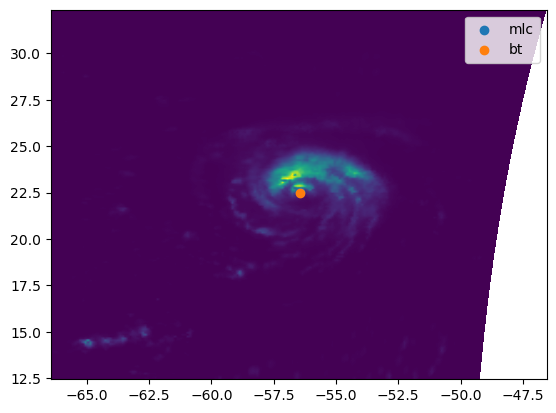

In [10]:
mid_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=6).values
mid_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=6).values

dist_to_mid_center = pointdist_calc(mid_lat,mid_lon,centering_lat,centering_lon)

# This is NOT a perfect estimate of the angle, given the Earth's curvature

angle_to_mlc = get_angle(centering_lon,centering_lat,mid_lon,mid_lat) # degrees from math angle zero, or east
plt.pcolormesh(eq_lon_grid,eq_lat_grid,eq_dist_data)
plt.scatter(mid_lon,mid_lat,label='mlc')
plt.scatter(centering_lon,centering_lat,label='bt')
plt.legend()
print(centering_lon,centering_lat,mid_lon,mid_lat,angle_to_mlc)

In [19]:
finalx,finaly = np.meshgrid(pd_last_slice.columns,pd_last_slice.index)

full_info_pd = pd.DataFrame(full_info_arr_list,columns=full_info_col_names)
vmax_arr_pd = pd.DataFrame(vmax_arr_list,columns=tc_radar_data['vmax_ships']['num_ships_times'].values)

finalx,finaly = np.meshgrid(pd_last_slice.columns,pd_last_slice.index)

all_last_slices_xr = xr.DataArray(all_last_slices,dims=["case","x", "y"],coords=dict(
        x=(["x", "y"], finalx),
        y=(["x", "y"], finaly)
    ))

# if sorting_type == 'tilt':

# Sort by Tilt Variables

weak_storms_info_pd = full_info_pd.where(full_info_pd['Intensity'] <= 65).dropna() # kt (threshold for weak storms)
small_tilt_indices = weak_storms_info_pd.where(weak_storms_info_pd['Tilt Magnitude'] < 40).dropna().index
large_tilt_indices = weak_storms_info_pd.where(weak_storms_info_pd['Tilt Magnitude'] >= 40).dropna().index    

small_tilt_cases = all_last_slices_xr.sel(case = small_tilt_indices)
small_tilt_rmws = full_info_pd.loc[small_tilt_indices]['RMW']
small_tilt_mlcs_x = full_info_pd.loc[small_tilt_indices]['MLC X']
small_tilt_mlcs_y = full_info_pd.loc[small_tilt_indices]['MLC Y']
large_tilt_cases = all_last_slices_xr.sel(case = large_tilt_indices)
large_tilt_rmws = full_info_pd.loc[large_tilt_indices]['RMW']
large_tilt_mlcs_x = full_info_pd.loc[large_tilt_indices]['MLC X']
large_tilt_mlcs_y = full_info_pd.loc[large_tilt_indices]['MLC Y']

# Sort by Intensity Variables
weak_indices = full_info_pd.where(full_info_pd['Intensity'] <=65).dropna().index
strong_indices = full_info_pd.where(full_info_pd['Intensity'] > 65).dropna().index
weak_cases_imerg = all_last_slices_xr.sel(case = weak_indices)
strong_cases_imerg = all_last_slices_xr.sel(case = strong_indices)
weak_cases_rmw = full_info_pd.loc[weak_indices]['RMW']
strong_cases_rmw = full_info_pd.loc[strong_indices]['RMW']

# Sort by Intensity Change

future_time = 12
future_change = vmax_arr_pd[future_time]-vmax_arr_pd[0]

shear_criteria = 'none'

if shear_criteria == 'none':
    RI_cases = future_change.where(future_change >= 20).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20)).dropna()
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5)).dropna()
    Weakening_cases = future_change.where(future_change < -5).dropna()
if shear_criteria == 'moderate':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()

if shear_criteria == 'moderate or stronger':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()

RI_imerg_data = all_last_slices_xr.sel(case = RI_cases.index)
intensifying_imerg_data = all_last_slices_xr.sel(case = Intensifying_cases.index)
SS_imerg_data = all_last_slices_xr.sel(case = SS_cases.index)
weakening_imerg_data = all_last_slices_xr.sel(case = Weakening_cases.index)

RI_rmw = full_info_pd.loc[RI_cases.index]['RMW']
intensifying_rmw = full_info_pd.loc[Intensifying_cases.index]['RMW']
SS_rmw = full_info_pd.loc[SS_cases.index]['RMW']
Weakening_rmw = full_info_pd.loc[Weakening_cases.index]['RMW']

In [20]:
RI_stats = np.mean(full_info_pd.loc[RI_cases.index],axis=0)
Intensifying_stats = np.mean(full_info_pd.loc[Intensifying_cases.index],axis=0)
SS_stats = np.mean(full_info_pd.loc[SS_cases.index],axis=0)
Weakening_stats = np.mean(full_info_pd.loc[Weakening_cases.index],axis=0)

# print(RI_stats,Intensifying_stats,SS_stats,Weakening_stats)

pd.DataFrame(Intensifying_stats,columns=['Intensifying']).transpose()

Tilt Magnitude Intensity        RMW Deep-Layer Shear      MLC X  \
Intensifying      20.169384  73.43254  61.238095        13.694851  16.799145   

                 MLC Y  
Intensifying  1.174525

In [ ]:
# Plot composites by tilt

large_tilt_mean = large_tilt_cases.mean('case')
small_tilt_mean = small_tilt_cases.mean('case')

large_tilt_Z = 300*(large_tilt_mean **(1.35))
large_tilt_dBZ = 10*np.log10(large_tilt_Z)

small_tilt_Z = 300*(small_tilt_mean **(1.35))
small_tilt_dBZ = 10*np.log10(small_tilt_Z)


# Identify mean MLC X and Y

mean_large_tilt_mlc_x = large_tilt_mlcs_x.mean()
mean_large_tilt_mlc_y = large_tilt_mlcs_y.mean()
mean_small_tilt_mlc_x = small_tilt_mlcs_x.mean()
mean_small_tilt_mlc_y = small_tilt_mlcs_y.mean()

mode = 'dBZ'

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Draw Circle

X,Y,THETA = circle([0,0],small_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    weak_cf = ax.contourf(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ,np.arange(18,42.1,2))
#     weak_cf = ax.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ)
    plt.colorbar(weak_cf,label='Reflectivity (dBZ)')
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ax.legend()
elif mode == 'Precip':
    weak_cf = ax.contourf(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_mean,levels=np.arange(0,12.1,1))
    plt.colorbar(weak_cf,label='Precipitation (mm/h)')
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ax.legend()

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

X2,Y2,THETA2 = circle([0,0],large_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    cf2 = ax2.contourf(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_dBZ,levels=np.arange(18,42.1,2))
#     cf2 = ax2.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_dBZ)
    plt.colorbar(cf2,label='Reflectivity (dBZ)')
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.grid()
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ax2.legend()

elif mode == 'Precip':
    cf2 = ax2.contourf(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_mean,levels=np.arange(0,12.1,1))
    plt.colorbar(cf2,label='Precipitation (mm/h)')
    ax2.grid()
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ax2.legend()

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if mode == 'dBZ':
    ax_cf = ax3.contourf(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ-large_tilt_dBZ,cmap='bwr',
                         levels=np.arange(-8,8.1,1))
#     ax_cf = ax3.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ-large_tilt_dBZ,cmap='bwr')
    plt.colorbar(ax_cf,label='Small – Large Tilt Reflectivity Difference (dBZ)')
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ax3.grid()
elif mode == 'Precip':
    ax_cf = ax3.contourf(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_mean-large_tilt_mean,cmap='bwr',
                         levels=np.arange(-5,5.1,1))
    plt.colorbar(ax_cf,label='Small – Large Tilt Precipitation Difference (mm/h)')
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ax3.grid()
axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)


plt.figure()
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Small Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Large Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)
axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)

axhist.set_xticks(np.arange(0,180,40))
axhist.set_xlabel('Tilt Magnitude (km)')
axhist.set_ylabel('Number of Cases')
plt.legend()


In [8]:
small_tilt_mean[129,5].values,large_tilt_mean[129,5].values,(small_tilt_mean-large_tilt_mean)[129,5].values

(array(1.70837482), array(0.54799189), array(1.16038293))

In [9]:
small_tilt_dBZ[129,5].values,large_tilt_dBZ[129,5].values,(small_tilt_dBZ-large_tilt_dBZ)[129,5].values

(array(27.91108525), array(21.24466333), array(6.66642192))

In [10]:
small_tilt_mean[100,75].values,large_tilt_mean[100,75].values,(small_tilt_mean-large_tilt_mean)[100,75].values

(array(6.65761125), array(3.26198182), array(3.39562944))

In [11]:
small_tilt_dBZ[100,75].values,large_tilt_dBZ[100,75].values,(small_tilt_dBZ-large_tilt_dBZ)[100,75].values

(array(35.88601139), array(31.70321328), array(4.18279811))

/tmp/ipykernel_79670/780817494.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


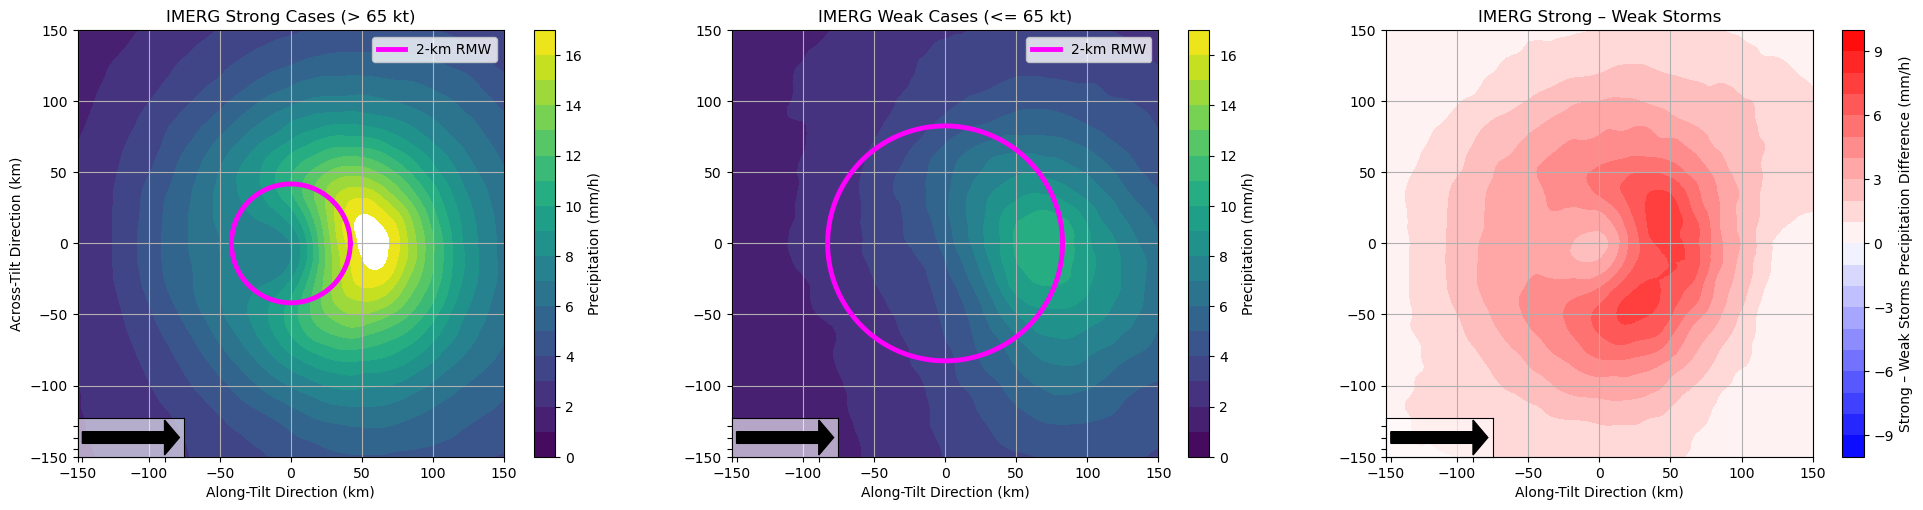

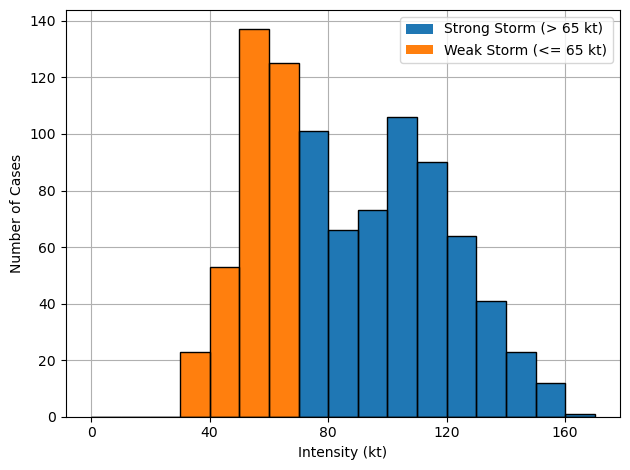

In [12]:
# Plot composites by intensity

strong_cases_imerg_mean = strong_cases_imerg.mean('case')
weak_cases_imerg_mean = weak_cases_imerg.mean('case')

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Draw Circle

X,Y,THETA = circle([0,0],strong_cases_rmw.mean(),1000)

weak_cf = ax.contourf(x_evenly_last_sliced, y_evenly_last_sliced,strong_cases_imerg_mean,levels=np.arange(0,17.1,1))
plt.colorbar(weak_cf,label='Precipitation (mm/h)')
ax.grid()
ax.set_title('IMERG Strong Cases (> 65 kt)')
ax.set_xlabel('Along-Tilt Direction (km)')
ax.set_ylabel('Across-Tilt Direction (km)')
ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.legend()

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

X2,Y2,THETA2 = circle([0,0],weak_cases_rmw.mean(),1000)

cf2 = ax2.contourf(x_evenly_last_sliced, y_evenly_last_sliced,weak_cases_imerg_mean,levels=np.arange(0,17.1,1))
plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.grid()
ax2.set_title('IMERG Weak Cases (<= 65 kt)')
ax2.set_xlabel('Along-Tilt Direction (km)')
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.legend()

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax_cf = ax3.contourf(x_evenly_last_sliced, y_evenly_last_sliced,strong_cases_imerg_mean-weak_cases_imerg_mean,
                     cmap='bwr',levels=np.arange(-10,10.1,1))
plt.colorbar(ax_cf,label='Strong – Weak Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG Strong – Weak Storms')
ax3.set_xlabel('Along-Tilt Direction (km)')
ax3.grid()
axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

plt.tight_layout()

plt.figure()
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(full_info_pd.loc[strong_indices]['Intensity'], histtype='bar',
         bins=np.arange(0,180,10),label='Strong Storm (> 65 kt)',rwidth=1)
axhist.hist(full_info_pd.loc[weak_indices]['Intensity'], histtype='bar',
         bins=np.arange(0,180,10),label='Weak Storm (<= 65 kt)',rwidth=1)
axhist.hist(full_info_pd.loc[strong_indices]['Intensity'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)
axhist.hist(full_info_pd.loc[weak_indices]['Intensity'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)

axhist.set_xticks(np.arange(0,180,40))
axhist.set_xlabel('Intensity (kt)')
axhist.set_ylabel('Number of Cases')
plt.legend()
plt.tight_layout()

/tmp/ipykernel_79670/3073368438.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


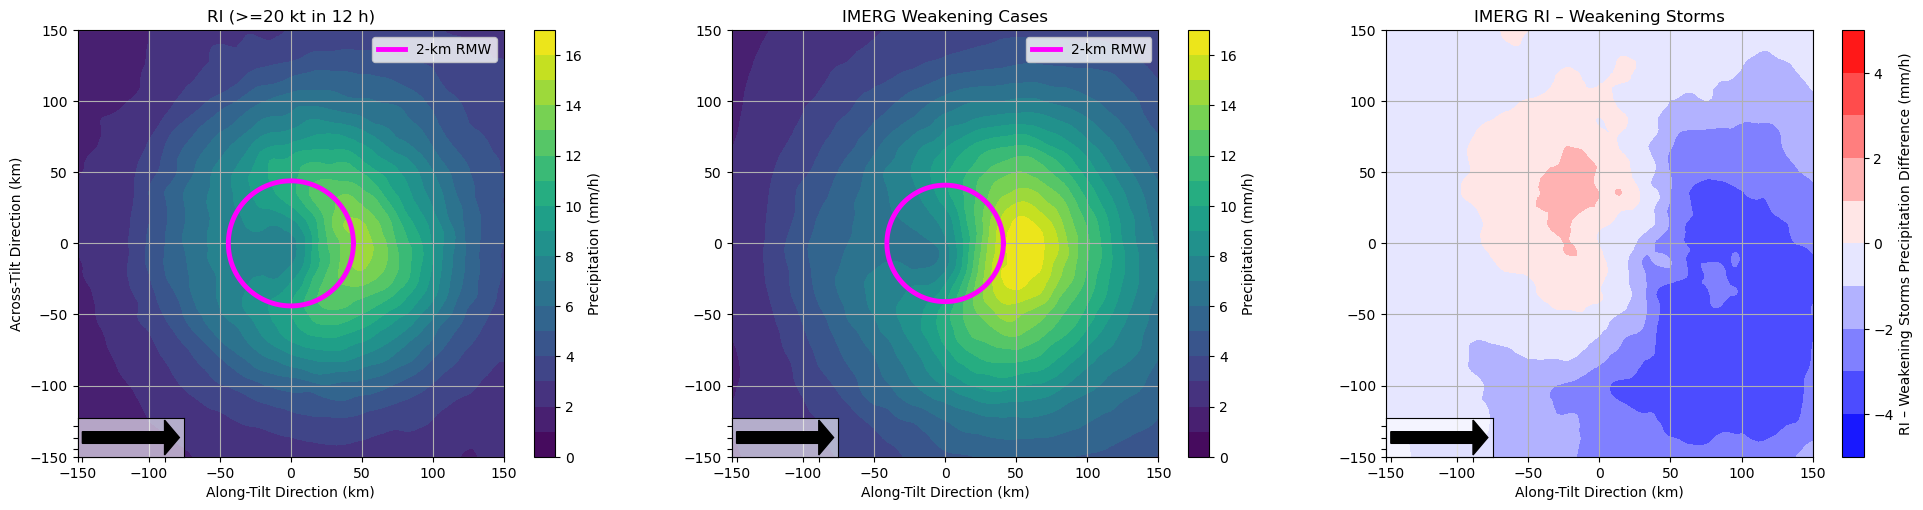

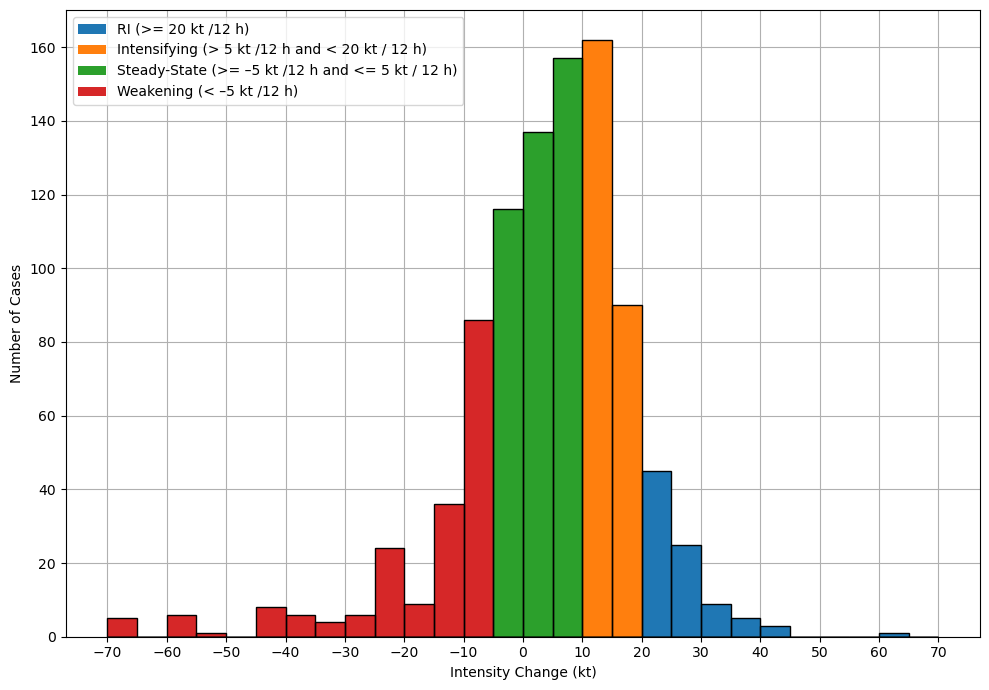

In [13]:
# Plot composites by intensity CHANGE

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Draw Circle

X,Y,THETA = circle([0,0],RI_rmw.mean(),1000)

weak_cf = ax.contourf(x_evenly_last_sliced, y_evenly_last_sliced,RI_imerg_data.mean('case'),
                      levels=np.arange(0,17.1,1))
plt.colorbar(weak_cf,label='Precipitation (mm/h)')
ax.grid()
ax.set_title('RI (>=20 kt in 12 h)')
ax.set_xlabel('Along-Tilt Direction (km)')
ax.set_ylabel('Across-Tilt Direction (km)')
ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.legend()

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

intensity_change_choice = 'Weakening'

if intensity_change_choice == 'Weakening':
    X2,Y2,THETA2 = circle([0,0],Weakening_rmw.mean(),1000)
    data_choice = weakening_imerg_data
elif intensity_change_choice == 'Steady-State':
    X2,Y2,THETA2 = circle([0,0],SS_rmw.mean(),1000)
    data_choice = SS_imerg_data
elif intensity_change_choice == 'Intensifying':
    X2,Y2,THETA2 = circle([0,0],intensifying_rmw.mean(),1000)
    data_choice = intensifying_imerg_data


cf2 = ax2.contourf(x_evenly_last_sliced, y_evenly_last_sliced,data_choice.mean('case'),
                   levels=np.arange(0,17.1,1))
plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.grid()
ax2.set_title('IMERG ' + intensity_change_choice + ' Cases')
ax2.set_xlabel('Along-Tilt Direction (km)')
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.legend()

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax_cf = ax3.contourf(x_evenly_last_sliced, y_evenly_last_sliced,RI_imerg_data.mean('case')-data_choice.mean('case'),
                     cmap='bwr',levels=np.arange(-5,5.1,1))
plt.colorbar(ax_cf,label='RI – ' +str(intensity_change_choice) +' Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG RI – ' +str(intensity_change_choice) +' Storms')
ax3.set_xlabel('Along-Tilt Direction (km)')
ax3.grid()
axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False)
axins.patch.set_alpha(0.6)
q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

plt.tight_layout()

plt.figure(figsize=(10,7))
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(future_change.loc[RI_cases.index], histtype='bar',
         bins=np.arange(-70,70.1,5),label='RI (>= 20 kt /12 h)',rwidth=1)
axhist.hist(future_change.loc[Intensifying_cases.index], histtype='bar',
         bins=np.arange(-70,70.1,5),label='Intensifying (> 5 kt /12 h and < 20 kt / 12 h)',rwidth=1)
axhist.hist(future_change.loc[SS_cases.index], histtype='bar',
         bins=np.arange(-70,70.1,5),label='Steady-State (>= –5 kt /12 h and <= 5 kt / 12 h)',rwidth=1)
axhist.hist(future_change.loc[Weakening_cases.index], histtype='bar',
         bins=np.arange(-70,70.1,5),label='Weakening (< –5 kt /12 h)',rwidth=1)
axhist.hist(future_change.loc[RI_cases.index],
         bins=np.arange(-70,70.1,5),rwidth=1, fill=False)
axhist.hist(future_change.loc[Intensifying_cases.index],
         bins=np.arange(-70,70.1,5),rwidth=1, fill=False)
axhist.hist(future_change.loc[SS_cases.index],
         bins=np.arange(-70,70.1,5),rwidth=1, fill=False) 
axhist.hist(future_change.loc[Weakening_cases.index],
         bins=np.arange(-70,70.1,5),rwidth=1, fill=False) 
              
axhist.set_xticks(np.arange(-70,70.1,10))
axhist.set_xlabel('Intensity Change (kt)')
axhist.set_ylabel('Number of Cases')
plt.legend()
plt.tight_layout()

In [10]:
# # Calculate average RMW for Small-Tilt Storms

# small_rmw_mean = np.mean(np.asarray(rmw_small_tilt))

# # Draw Circle

# X,Y,THETA = circle([0,0],small_rmw_mean,1000)

# # Make Plot
# plt.figure(figsize=(10,8))
# ax = plt.axes()
# weak_cf = ax.contourf(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_mean,levels=np.arange(0,12.1,1))
# plt.colorbar(weak_cf,label='Precipitation (mm/h)')
# ax.grid()
# ax.set_title('IMERG Small-Tilt')
# ax.set_xlabel('Along-Tilt Direction (km)')
# ax.set_ylabel('Across-Tilt Direction (km)')
# ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
# ax.legend()

# axins = inset_axes(ax, width="25%", height="9%",
#                    bbox_transform=ax.transAxes, loc=3, borderpad=0)
# axins.tick_params(labelleft=False, labelbottom=False)
# axins.patch.set_alpha(0.8)
# q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

In [11]:
# # Calculate average RMW for Large-Tilt Storms

# large_rmw_mean = np.mean(np.asarray(rmw_large_tilt))

# # Draw Circle

# X2,Y2,THETA2 = circle([0,0],large_rmw_mean,1000)

# # Make Plot

# plt.figure(figsize=(10,8))
# ax2 = plt.axes()
# cf2 = ax2.contourf(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_mean,levels=np.arange(0,12.1,1))
# plt.colorbar(cf2,label='Precipitation (mm/h)')
# ax2.grid()
# ax2.set_title('IMERG Large-Tilt')
# ax2.set_xlabel('Along-Tilt Direction (km)')
# ax2.set_ylabel('Across-Tilt Direction (km)')
# ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
# ax2.legend()

# axins2 = inset_axes(ax2, width="25%", height="9%",
#                    bbox_transform=ax.transAxes, loc=3, borderpad=0)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins2.patch.set_alpha(0.8)
# q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

In [12]:
# plt.scatter(tc_radar_data.sel(num_cases=case_loop)['tc_center_longitudes'],tc_radar_data.sel(num_cases=case_loop)['tc_center_latitudes'],c=tc_radar_data['level'])
# plt.colorbar()